In [1]:
# thompson.py

from scipy.stats import beta
import numpy as np
from scipy.stats import bernoulli
from scipy.stats import norm

print("Begin Thompson demo ")

################################## Initiate Parameters for the scripts ##################################
# initialize distributions
prob_model = 0 # 0 for bernoulli, 1 for gaussian
#global prior_distribution, rewards_distribution, true_prob

def initial_condition(prob_model):
    global prior_distribution, rewards_distribution, true_prob
    if prob_model == 0:
        prior_distribution = beta #norm
        rewards_distribution = bernoulli #norm
    else:
        prior_distribution = norm
        rewards_distribution = norm

    # actual probabilities of different arms
    #true_prob = np.array([])
    if rewards_distribution == bernoulli:
        true_prob = np.array([0.2, 0.6, 0.5])

    elif rewards_distribution == norm:
        true_prob = np.array([[0.3,10],[0.5,10], [0.6,10]])

# How many rounds to play equivalent to Time horizon.
rounds = 100000

# number of posterior plots
plot_row = 3
plot_col = 2

# number of parameters required by prior distribution
parameters_num = 2

initial_condition(prob_model)
################################################# scripts started ######################################
# total number of plots about beta distributions 
plot_num = plot_row * plot_col

# number of arms
size = len(true_prob)

# rewards
rewards = np.zeros(rounds)
rewards_per_round = np.zeros((size,rounds), dtype=float)

# cumulative rewards
cumulative_rewards = np.zeros(rounds)

# Initiate Priors
if rewards_distribution == bernoulli:
    hyperparameters = np.ones((size,parameters_num), dtype=int) #index 0 is alpha and index 1 is beta
elif rewards_distribution == norm:
    hyperparameters = np.full((size,2), [0,1]) #index 0 is mean and index 2 is variance

print("hyperparameters are", hyperparameters)
hyperparameters_records = np.empty((plot_num, size, parameters_num), dtype=float)

# The folloinwg represents the rounds we select to plot poster distributions
posterior_rounds = np.linspace(0, rounds-1, plot_num).astype(int)
print("posterior rounds are", posterior_rounds)

# Initiate regrets
regret_per_round = np.zeros(rounds) 
cumulated_regrets = np.zeros(rounds)

# Initialize the expected value of each arm with posteriors from the previous round
thetas = np.ones(size, dtype = float) 

# Initialize record for best_arm
best_arm = np.zeros(rounds,dtype = int)

##################################### Complementary Functions ########################################

# Thompson sampling     
def sampling(size, t):
    global thetas   
    thetas = prior_distribution.rvs(hyperparameters[:,0], hyperparameters[:,1])
    

    
# # sampling_records represnet the entire records to thetas for arms
# single_record = np.empty(rounds, dtype = float)
# sampling_records = np.full((size,rounds), single_record)

# # record the expected 
# def record_thetas(lines, thetas, size, column):
#     lines[:, column] = thetas

def record_rewards(t, chosen_arm, reward):
    # update rewards and rewards_per_round
    rewards[t] = reward
    #print(reward)
    rewards_per_round[chosen_arm, t] = reward
    #print(reward)
    
    #update cumulative rewards
    if t > 0:
        cumulative_rewards[t] = reward + cumulative_rewards[t-1] 
    else:
        cumulative_rewards[t] = reward
        
    #register_regret(chosen_arm, t)
    
# Get the expected reward of the chosen arm
def get_expected_reward(chosen, t): 
    # this obtains the empirical expected rewards
    # sum the rewards up to round t-1, including round 0. t represents the current round
    if t:
        return np.sum(rewards_per_round[chosen][:t])/t
    return 0

# Register the regret
def register_regret(chosen,t):
    # Calculate regrets
    if rewards_distribution == bernoulli:
        regret =  max(true_prob) - get_expected_reward(chosen,t)
        
        regret_per_round[t] = regret
    else:
        best_reward = max(true_prob[:,0])
        #print(best_reward)
        regret = best_reward - get_expected_reward(chosen,t)
        #print(chosen)
        #print(get_expected_reward(chosen,t))
        regret_per_round[t] = regret
        
    if t > 0:
        cumulated_regrets[t] = regret + cumulated_regrets[t-1] 
    else:
        cumulated_regrets[t] = regret


# Record posteriors
def record_posteriors(round_num, hyperparameters):
    
    if round_num in posterior_rounds:
        index = np.where(posterior_rounds==round_num)
        hyperparameters_records[index[0]] = hyperparameters
        #print(1)
    #np.append(posteriors_records, np.full((1,size,prior_parameters_num),posteriors, dtype=int), axis=0)

    
def update_posteriors(t, reward, chosen_arm):
    # Update distribution parameters alpha and beta for each arm
    if rewards_distribution == bernoulli:
        if reward:
            hyperparameters[chosen_arm][0] += 1
        else:
            hyperparameters[chosen_arm][1] += 1
    else:
        
        cur_mean = hyperparameters[chosen_arm][0]
        cur_variance = hyperparameters[chosen_arm][1]
        data_point = reward
        true_variance = true_prob[chosen_arm][1]
        
        hyperparameters[chosen_arm][0] = (cur_variance * data_point + true_variance * cur_mean )/ (cur_variance + true_variance)
        hyperparameters[chosen_arm][1] = 1/(1/cur_variance + 1/true_variance) #cur_variance * prior_variance /(cur_variance + prior_variance)
        #print(cur_variance)
            
def stats():
    # return the mean and the variance of regrets per realization
    return (regret_per_round.mean(), regret_per_round.var())

def start():
    for i in range(rounds):

        # Delayed Rewards
        if (i % 10 == 0):
            # call function by its use
            sampling(size, i)

            #record_thetas(lines, thetas, size, i)
            chosen_arm = thetas.argmax()
            best_arm[i] = chosen_arm
            # by choosing the best theta, determine the best arm
        else:
            chosen_arm = best_arm[i-1]
            best_arm[i] = chosen_arm
            
        # Immediate Rewards:
        #sampling(size, i)

        #record_thetas(lines, thetas, size, i)
        chosen_arm = thetas.argmax()
        best_arm[i] = chosen_arm
        
        # apply this arm and observe the rewards. # question: do we use the calculauted result from above 
        #or need to apply the arm again
        if rewards_distribution == bernoulli:
            r = rewards_distribution.rvs(p = true_prob[best_arm[i]])
            
        else:
            params = true_prob[chosen_arm]
            r = rewards_distribution.rvs(params[0], params[1])

        record_rewards(i, chosen_arm, r)

        register_regret(chosen_arm, i)

        update_posteriors(i, r,chosen_arm)

        record_posteriors(i, hyperparameters)
    
start()

#
    
#intermediate_priors = np.array(intermediate_priors)
#print(posteriors_records)


Begin Thompson demo 
hyperparameters are [[1 1]
 [1 1]
 [1 1]]
posterior rounds are [    0 19999 39999 59999 79999 99999]


In [2]:
from scipy.stats import randint
p1 = randint(1,3)
p1.rvs(1)

array([2])

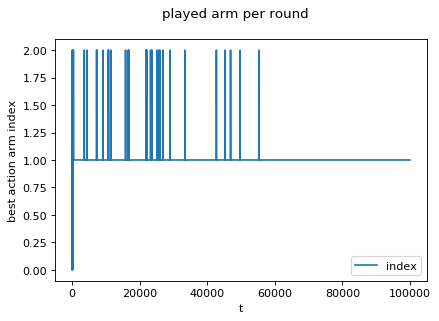

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['savefig.dpi'] = 80 # size parameter for inline
mpl.rcParams['figure.dpi'] = 100 # size parameter for notebook
x_axis = range(rounds)

def plot_arms(best_arm):
    fig = plt.figure()
    line_1, = plt.plot(x_axis, best_arm, label='index')
    plt.ylabel('best action arm index')
    plt.xlabel('t')
    plt.legend(loc="lower right",handles=[line_1])
    fig.suptitle("played arm per round")
    fig.savefig('test.jpg')
    plt.show()

plot_arms(best_arm)

C:\Users\lucas\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:532: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002121FF56358> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


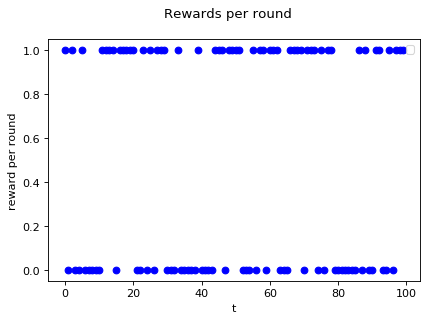

In [3]:
def plot_rewards(rewards):
    fig = plt.figure()
    line_1, = plt.plot(x_axis[:100], rewards[:100], 'bo')
    #print(rewards)
    plt.ylabel('reward per round')
    plt.xlabel('t')
    plt.legend(handles=[line_1])
    fig.suptitle("Rewards per round")
    fig.savefig('test.jpg')
    plt.show()
    
plot_rewards(rewards)

C:\Users\lucas\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:532: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000021220059CF8> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


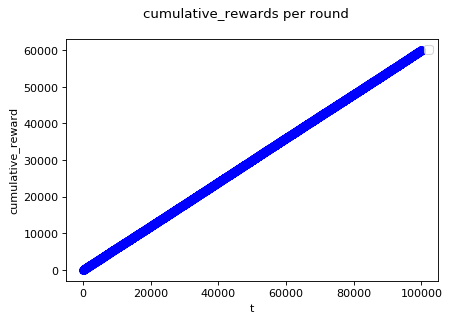

In [4]:
def plot_cumulative_rewards(cumulative_rewards):
    fig = plt.figure()
    line_1, = plt.plot(x_axis, cumulative_rewards, 'bo')

    plt.ylabel('cumulative_reward')
    plt.xlabel('t')
    plt.legend(handles=[line_1])
    fig.suptitle("cumulative_rewards per round")
    fig.savefig('test.jpg')
    plt.show()
    
plot_cumulative_rewards(cumulative_rewards)

C:\Users\lucas\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:532: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000021220257908> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


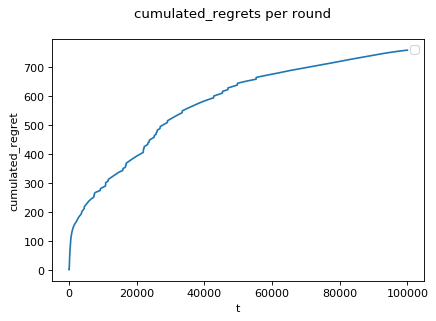

In [5]:
def plot_cumulated_regrets(cumulated_regrets):
    fig = plt.figure()
    line_1, = plt.plot(x_axis,cumulated_regrets)

    plt.ylabel('cumulated_regret')
    plt.xlabel('t')
    plt.legend(handles=[line_1])
    fig.suptitle("cumulated_regrets per round")
    fig.savefig('test.jpg')
    plt.show()
    
plot_cumulated_regrets(cumulated_regrets)

In [22]:
# Get variance

trials = 10
trial_rounds = [1000 * 2 ** i for i in range(6)]
regret_variance = np.zeros(len(trial_rounds))
for (index, rounds) in enumerate(trial_rounds):
    #regrets = np.zeros(trials)
 
    # How many rounds to play equivalent to Time horizon.

    # number of parameters required by prior distribution
    parameters_num = 2

    initial_condition(prob_model=0)
    ################################################# scripts started ######################################
    # total number of plots about beta distributions 
    plot_num = plot_row * plot_col

    # number of arms
    size = len(true_prob)

    # rewards
    rewards = np.zeros(rounds)
    rewards_per_round = np.zeros((size,rounds), dtype=float)

    # cumulative rewards
    cumulative_rewards = np.zeros(rounds)

    # Initiate Priors
    if rewards_distribution == bernoulli:
        hyperparameters = np.ones((size,parameters_num), dtype=int) #index 0 is alpha and index 1 is beta
    elif rewards_distribution == norm:
        hyperparameters = np.full((size,2), [0,1]) #index 0 is mean and index 2 is variance

    print("hyperparameters are", hyperparameters)
    hyperparameters_records = np.empty((plot_num, size, parameters_num), dtype=float)

    # The folloinwg represents the rounds we select to plot poster distributions
    posterior_rounds = np.linspace(0, rounds-1, plot_num).astype(int)
    print("posterior rounds are", posterior_rounds)

    # Initiate regrets
    regret_per_round = np.zeros(rounds) 
    cumulated_regrets = np.zeros(rounds)

    # Initialize the expected value of each arm with posteriors from the previous round
    thetas = np.ones(size, dtype = float) 

    # Initialize record for best_arm
    best_arm = np.zeros(rounds,dtype = int)

    for i in range(rounds):

        # Delayed Rewards
        if (i % 10 == 0):
            # call function by its use
            sampling(size, i)

            #record_thetas(lines, thetas, size, i)
            chosen_arm = thetas.argmax()
            best_arm[i] = chosen_arm
            # by choosing the best theta, determine the best arm
        else:
            chosen_arm = best_arm[i-1]
            best_arm[i] = chosen_arm

        # Immediate Rewards:
        #sampling(size, i)

        #record_thetas(lines, thetas, size, i)
        chosen_arm = thetas.argmax()
        best_arm[i] = chosen_arm

        # apply this arm and observe the rewards. # question: do we use the calculauted result from above 
        #or need to apply the arm again
        if rewards_distribution == bernoulli:
            r = rewards_distribution.rvs(p = true_prob[best_arm[i]])

        else:
            params = true_prob[chosen_arm]
            r = rewards_distribution.rvs(params[0], params[1])

        record_rewards(i, chosen_arm, r)

        register_regret(chosen_arm, i)

        update_posteriors(i, r,chosen_arm)

        record_posteriors(i, hyperparameters)
            
        regrets[t] = cumulated_regrets[-1]
    
    #print(regrets)
    regret_variance[index] = np.var(regret_per_round)

    
print(regret_variance)    

hyperparameters are [[1 1]
 [1 1]
 [1 1]]
posterior rounds are [  0 199 399 599 799 999]
hyperparameters are [[1 1]
 [1 1]
 [1 1]]
posterior rounds are [   0  399  799 1199 1599 1999]
hyperparameters are [[1 1]
 [1 1]
 [1 1]]
posterior rounds are [   0  799 1599 2399 3199 3999]
hyperparameters are [[1 1]
 [1 1]
 [1 1]]
posterior rounds are [   0 1599 3199 4799 6399 7999]
hyperparameters are [[1 1]
 [1 1]
 [1 1]]
posterior rounds are [    0  3199  6399  9599 12799 15999]
hyperparameters are [[1 1]
 [1 1]
 [1 1]]
posterior rounds are [    0  6399 12799 19199 25599 31999]
[ 0.01854613  0.01082112  0.00972421  0.01059934  0.0038737   0.00380615]


C:\Users\lucas\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:532: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000029712D65A20> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


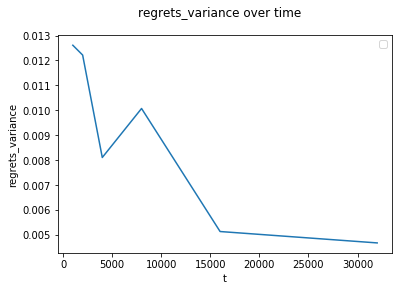

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
def plot_regrets_variance(regrets_variance):
    fig = plt.figure()
    x_axis = trial_rounds
    line_1, = plt.plot(x_axis,regrets_variance)

    plt.ylabel('regrets_variance')
    plt.xlabel('t')
    plt.legend(handles=[line_1])
    fig.suptitle("regrets_variance over time")
    fig.savefig('test.jpg')
    plt.show()
    
plot_regrets_variance(regret_variance)

NameError: name 'single_plot' is not defined

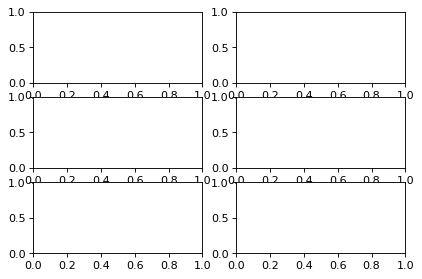

In [21]:
def get_rv(i, k):
    return beta(hyperparameters_records[i][k][0], hyperparameters_records[i][k][1])

def plot_all(axarr):
    #for ax in axarr:
    count = 0
    for i in range(plot_row):
        for j in range(plot_col):
            single_plot(axarr[i,j], count)
            count+=1
def plot_beta():
    #x = np.linspace(0, 1.0, 100)
    posteriors_plot = []

    plt.close('all')

    def single_plot(ax,j):

        x = np.linspace(0, 1.0, 100)

        vget_rv = np.vectorize(get_rv)
        # Getting forzen random variables of the given arms

        forzen_rvs = vget_rv(j, range(size))
    #     print(rvs)
    #    rvs_1 = beta(posteriors_records[i][:,0], posteriors_records[i][:,1])
    #     print(posteriors_records[i][:,1].shape)
    #     print(rvs_1)
        ys = np.empty(size, dtype=np.ndarray)
        means = np.empty(size,dtype=object)
        pdfs = np.empty(size,dtype=object)

        for i in range(size):
            ys[i] = forzen_rvs[i].pdf(x)
            means[i] = forzen_rvs[i].mean()
            pdfs[i] = forzen_rvs [i].pdf(means[i])

        global posteriors_plot
        colors = [('b','b--'),('g','g--'),('r','r--'),('c','c--'),('m','m--'),('k','k--')]
        # Maximum color index is 5
        for i in range(size):
            print(ys[i].shape)
            print(x.shape)
            p1, = ax.plot(x, ys[i], colors[i][0], label= 'p = %.2f' %(true_prob[i]))
            posteriors_plot.append(p1)
            ax.plot([means[i], means[i]], [0, pdfs[i]], colors[i][1])


        ax.set_title("Round %d" %(posterior_rounds[j]))

    f, axarr = plt.subplots(plot_row,plot_col)

    #f.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plot_all(axarr)

    #plt.legend(bbox_to_anchor = [1.05, 1.05],handles=posteriors_plot)
    plt.show()
    
plot_beta()

C:\Users\lucas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\lucas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


[[ 0.81494864  0.001     ]]


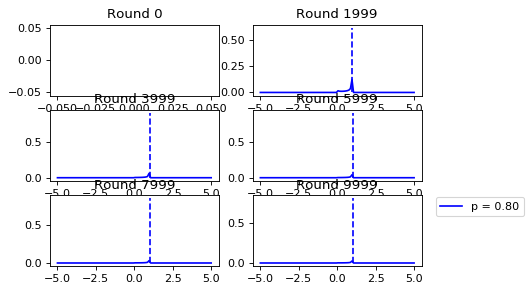

In [31]:

# Mean = 0, SD = 2.
plt.plot(x_axis, norm.pdf(x_axis,0,2))
import matplotlib.mlab as mlab
def plot_gaussian():
    x = np.linspace(-5.0, 5.0, 100)
    posteriors_plot = []
    plt.close('all')

    def plot_all(axarr):
        #for ax in axarr:
        count = 0
        for i in range(plot_row):
            for j in range(plot_col):
                single_plot(axarr[i,j], count)
                count+=1
            
    def single_plot(ax,j):
        #mu = hyperparameters_records[j][:,0]
        #sigma = hyperparameters_records[j][:,1]
        vget_rv = np.vectorize(get_rv)
        # Getting forzen random variables of the given arms

        forzen_rvs = vget_rv(j, range(size))
    #     print(rvs)
    #    rvs_1 = beta(posteriors_records[i][:,0], posteriors_records[i][:,1])
    #     print(posteriors_records[i][:,1].shape)
    #     print(rvs_1)
        ys = np.empty(size, dtype=np.ndarray)
        means = np.empty(size,dtype=object)
        pdfs = np.empty(size,dtype=object)

        for i in range(size):
            ys[i] = forzen_rvs[i].pdf(x)
            means[i] = forzen_rvs[i].mean()
            pdfs[i] = forzen_rvs [i].pdf(means[i])


        colors = [('b','b--'),('g','g--'),('r','r--'),('c','c--'),('m','m--'),('k','k--')]
        # Maximum color index is 5
        for i in range(size):
            #print(i)
            #print(ys[i])
            p1, = ax.plot(x, ys[i], colors[i][0], label= 'p = %.2f' %(true_prob[i][0]))
            #print(p1)
            if j == 1:
                # record legends only once
                posteriors_plot.append(p1)
            ax.plot([means[i], means[i]], [0, pdfs[i]], colors[i][1])


        ax.set_title("Round %d" %(posterior_rounds[j]))

    f, axarr = plt.subplots(plot_row,plot_col)
    plot_all(axarr)
    #single_plot(1)
    print(hyperparameters_records[5])
    #f.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    

    plt.legend(bbox_to_anchor = [1.05, 1.05],handles=posteriors_plot)
    plt.show()
    
plot_gaussian()

0.807478042 0.00015028554
[ 0.  0.  0. ...,  0.  0.  0.]


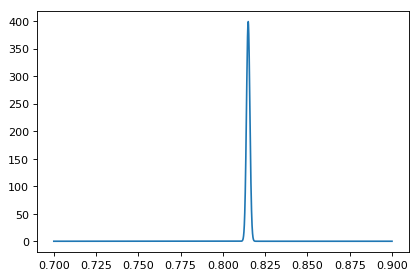

In [9]:
x = np.linspace(0.7, 0.9, 1000000)
param = np.array([[  8.07478042e-01,   1.50285540e-04],
 [  2.20702734e-01,   1.11109877e-01],
 [ -3.43966521e-01,   2.72719835e-01]])
print(param[0,0], param[0,1])
ys = norm.pdf(x, 0.81494864,  0.001 )

print(ys)
plt.plot(x,ys)